### Psychometric Model Sampling

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano

min_x = -10
max_x = 10
N = 10 # 10 trials at each orientation
x = np.linspace(min_x, max_x, 21) # the experiment is conducted at 21 x's
x_shared = theano.shared(x)
x_center = (min_x + max_x)/ 2
# t = np.linspace(-10, 10, 101)
bias = .8
sensitivity = 1.2

true_params = [sensitivity, bias]
labels_params = ['sensitivity', 'bias']
    
p_true = (1/(1 + np.exp(-(bias+true_params[0]*(x-x_center)) )))
np.random.seed(1234)
choices = (np.random.uniform(size=[N, np.size(p_true)]) < p_true).T * 1
observed_choices = np.sum(choices, 1)

In [11]:
observed_choices, p_true

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  2,  1,  6,  9, 10, 10, 10, 10, 10,
        10, 10, 10, 10]),
 array([1.36740091e-05, 4.53978687e-05, 1.50710358e-04, 5.00201107e-04,
        1.65880108e-03, 5.48629890e-03, 1.79862100e-02, 5.73241759e-02,
        1.67981615e-01, 4.01312340e-01, 6.89974481e-01, 8.80797078e-01,
        9.60834277e-01, 9.87871565e-01, 9.96315760e-01, 9.98887464e-01,
        9.99664650e-01, 9.99898971e-01, 9.99969568e-01, 9.99990834e-01,
        9.99997239e-01]))

In [12]:
np.random.seed(1234)
y_trial = pm.Binomial.dist(n=N, p = p_true)
y_trial.random(size=2)

array([[ 0,  0,  0,  0,  0,  0,  0,  1,  4,  6,  7,  9,  9, 10, 10, 10,
        10, 10, 10, 10, 10],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  2,  6,  7,  8, 10, 10, 10, 10,
        10, 10, 10, 10, 10]])

## Defining the model in PyMC3

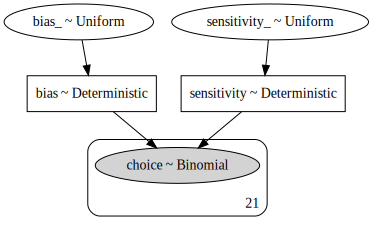

In [13]:
with pm.Model() as psychometricModel:
    
    sensitivity_ = pm.Uniform('sensitivity_', lower = .2, upper =1.5)
    bias_ = pm.Uniform('bias_', lower = -5, upper = 5)
    
    bias = pm.Deterministic("bias", bias_)
    sensitivity = pm.Deterministic("sensitivity", sensitivity_)
    
    p_ = ( 1/(1 + np.exp(-(bias+sensitivity*(x - x_center)) )))
    np.random.seed(1234)
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Binomial('choice', n=N, p=p_, observed = observed_choices)
pm.model_to_graphviz(psychometricModel)

## MAP Estimate

In [14]:
map_estimate = pm.find_MAP(model=psychometricModel)

map_estimate

logp = -9.3472, ||grad|| = 0.00020743: 100%|██████████| 35/35 [00:00<00:00, 2548.09it/s]  


{'sensitivity__interval__': array(17.1588825),
 'bias__interval__': array(0.18047932),
 'sensitivity_': array(1.49999995),
 'bias_': array(0.44997754),
 'bias': array(0.44997754),
 'sensitivity': array(1.49999995)}

## NUTS Sampler

In [16]:
with psychometricModel:
    trace = pm.sample(draws=2000, tune = 3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bias_, sensitivity_]
Sampling 4 chains, 0 divergences: 100%|██████████| 20000/20000 [00:03<00:00, 5078.47draws/s]
The acceptance probability does not match the target. It is 0.7194847410941214, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7171303235906474, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.885460037815507, but should be close to 0.8. Try to increase the number of tuning steps.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a312f4080>,
      dtype=object)

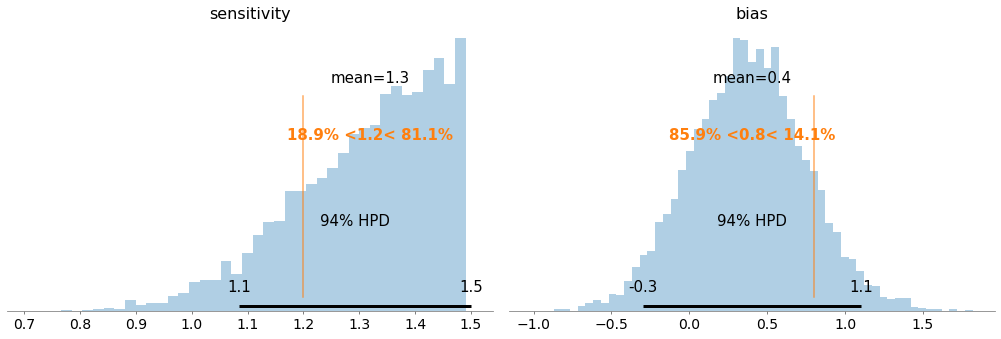

In [17]:
pm.plot_posterior(trace, var_names=['sensitivity', 'bias'], ref_val=list(true_params), kind="%hist")

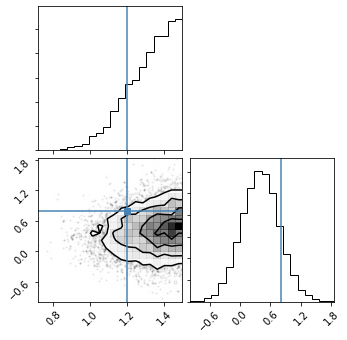

In [19]:
import corner
samples = np.vstack([trace[k] for k in ['sensitivity', 'bias']]).T
corner.corner(samples, truths=true_params);

/Users/hahuja/opt/anaconda3/envs/bayes3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/hahuja/opt/anaconda3/envs/bayes3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/hahuja/opt/anaconda3/envs/bayes3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/hahuja/opt/anaconda3/envs/bayes3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument b

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a26d6b9b0>,
      dtype=object)

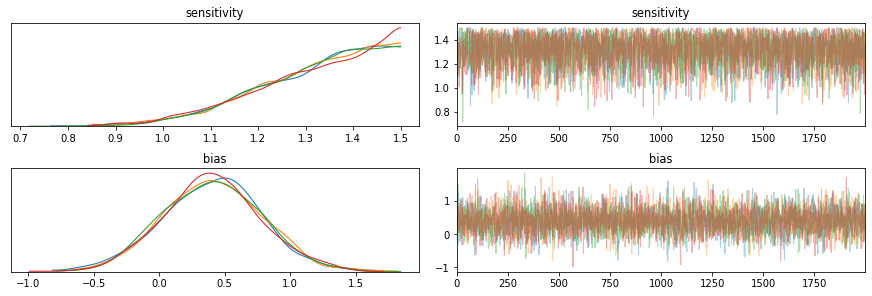

In [21]:
pm.plot_trace(trace, var_names=['sensitivity', 'bias'])

## MCMC

In [24]:
import theano

f = theano.function(psychometricModel.vars, [psychometricModel.logpt] + psychometricModel.deterministics)
    
def log_prob_func(params):
    dct = psychometricModel.bijection.rmap(params)
    args = (dct[k.name] for k in psychometricModel.vars)
    results = f(*args)
    return tuple(results)

In [25]:
import emcee

with psychometricModel:
    # First we work out the shapes of all of the deterministic variables
    res = pm.find_MAP()
    vec = psychometricModel.bijection.map(res)
    initial_blobs = log_prob_func(vec)[1:]
    dtype = [(var.name, float, np.shape(b)) for var, b in zip(psychometricModel.deterministics, initial_blobs)]
    
    # Then sample as usual
    coords = vec + 1e-5 * np.random.randn(25, len(vec))
    nwalkers, ndim = coords.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_func, blobs_dtype=dtype)
    sampler.run_mcmc(coords, 5000, progress=True)

logp = -9.3472, ||grad|| = 0.00020743: 100%|██████████| 35/35 [00:00<00:00, 3228.45it/s]  
100%|██████████| 5000/5000 [00:06<00:00, 806.00it/s]


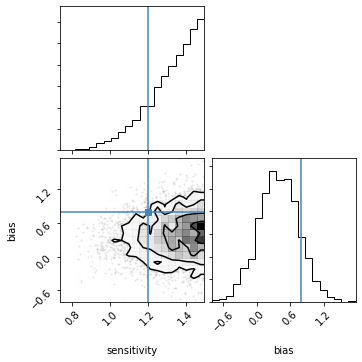

In [26]:
import pandas as pd
df = pd.DataFrame.from_records(sampler.get_blobs(flat=True, discard=100, thin=30))
corner.corner(df[["sensitivity", "bias"]], truths=true_params);

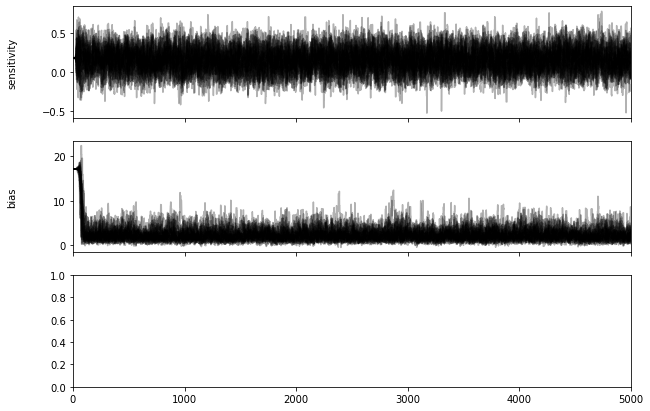

In [27]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["sensitivity", "bias"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha = .3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

In [28]:
tau = sampler.get_autocorr_time()
print(tau)

[32.13678366 70.05792161]
